In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd

In [2]:
n_agents = 14
data = [np.load("data/%s.npz"%(n+1)) for n in range(n_agents)]

In [3]:
cues = pd.read_csv('how_many_cues.csv', sep=';')
stim = pd.read_csv('input_stimuli.csv',sep=';')
choices = pd.read_csv('choices.csv', sep=';')
weights = np.array([0.706, 0.688, 0.667, 0.647, 0.625, 0.6]) # validity of cues (from experiment)

def read_values(trial):
    stim = pd.read_csv('input_stimuli.csv', sep=';')
    trdata = list(stim[['c1','c2','c3','c4','c5','c6','c1.1','c2.1','c3.1','c4.1','c5.1','c6.1']].loc[trial])
    A = trdata[:len(trdata)//2]
    B = trdata[len(trdata)//2:]
    return np.array([[A[n], B[n]] for n in range(len(A))])

def read_RT_empirical(participant, trial):
    cols = list(cues.columns)
    return list(cues[cols[participant+1]])[trial]

def read_choice(participant, trial):
    cols = list(choices.columns)
    return list(choices[cols[participant+1]])[trial]

def get_correct(values, weights):
    evidence_A = np.dot(values[:,0], weights)
    evidence_B = np.dot(values[:,1], weights)
    return np.argmax([evidence_A, evidence_B])

def get_accuracy_empirical(choice, trial):
    values = read_values(trial)
    correct = get_correct(values, weights)
    if choice == 'A' and correct == 0:
        return True
    if choice == 'B' and correct == 1:
        return True
    return False

def make_df():
    columns = ('trial', 'participant', 'accuracy', 'RT')
    df = pd.DataFrame(columns=columns)
    mean_RTs = np.zeros((14))
    mean_accuracies = np.zeros((14))
    n_partitipants =  14
    n_trials = 48
    for participant in range(n_partitipants):
        accuracies_participant = []
        RTs_participant = []
        for trial in range(n_trials):
            accuracy = get_accuracy_empirical(read_choice(participant, trial), trial)
            RT = read_RT_empirical(participant, trial)
            accuracies_participant.append(accuracy)
            RTs_participant.append(RT)
            df = df.append(pd.DataFrame([[participant, trial, accuracy, RT]], columns=columns), ignore_index=True)
        mean_RTs[participant] = np.mean(RTs_participant)
        mean_accuracies[participant] = np.mean(accuracies_participant)

        if participant == 0:
            RTs_human_fast = RTs_participant
            accuracies_human_fast = 100*np.mean(accuracies_participant)
        if participant == 12:
            RTs_human_slow = RTs_participant
            accuracies_human_slow = 100*np.mean(accuracies_participant)
            
    return mean_RTs, mean_accuracies, df

In [4]:
mean_RTs_human, mean_accuracies_human, df = make_df()

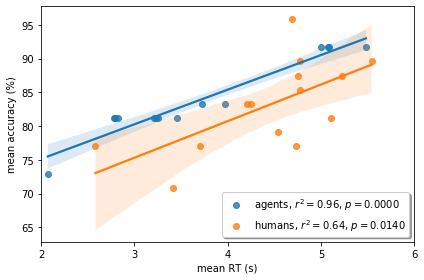

In [6]:
mean_RTs_agent = np.array([np.mean(D['RTs']) for D in data])
mean_accuracies_agent = np.array([np.mean(D['accuracies']) for D in data])
agent_r2, agent_p = scipy.stats.linregress(mean_RTs_agent, mean_accuracies_agent)[2:4]
human_r2, human_p = scipy.stats.linregress(mean_RTs_human, mean_accuracies_human)[2:4]
fig, ax = plt.subplots()
sns.regplot(mean_RTs_agent, 100*mean_accuracies_agent, label=r"agents, $r^2=%.2f$, $p=%.4f$"%(agent_r2, agent_p))
sns.regplot(mean_RTs_human, 100*mean_accuracies_human, label=r"humans, $r^2=%.2f$, $p=%.4f$"%(human_r2, human_p))
ax.set(xlabel='mean RT (s)', ylabel='mean accuracy (%)', xlim=((2, 6)), xticks=([2,3,4,5,6]))#, ylim=((50, 100))
ax.legend(loc='lower right', ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("plots/SAT_model.svg")
plt.savefig("plots/SAT_model.pdf")

In [ ]:
RTs_all = np.concatenate(([D['RTs'] for D in data])).ravel()

fig, ax = plt.subplots()
ax.hist(RTs_all, bins=np.array([1,2,3,4,5,6,7])-0.5, rwidth=1, density=True, label='agents (n=%s)'%n_agents)
ax.set(xlabel='reaction time (s)', ylabel='frequency', xticks=([1,2,3,4,5,6]), ylim=((0, 0.4)))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("plots/RT_distribution.pdf")

# OLD

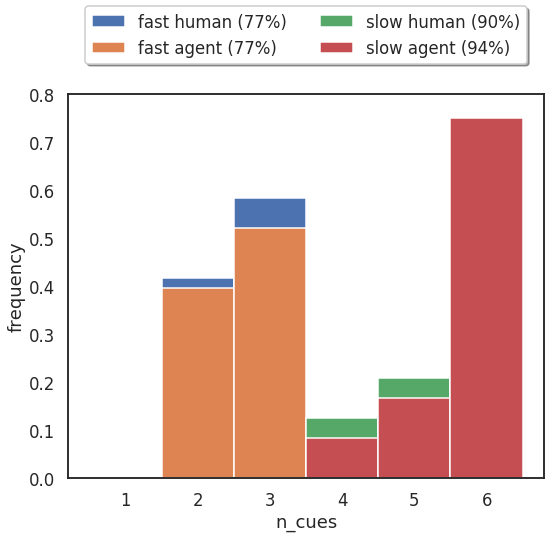

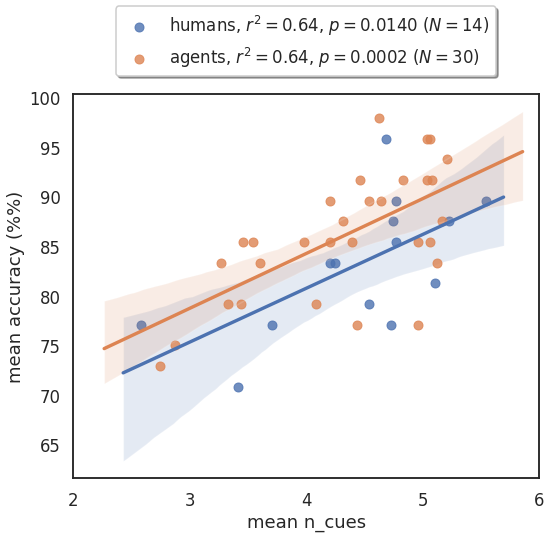

In [23]:
cues = pd.read_csv('how_many_cues.csv', sep=';')
stim = pd.read_csv('input_stimuli.csv',sep=';')
choices = pd.read_csv('choices.csv', sep=';')
validities = np.array([0.706, 0.688, 0.667, 0.647, 0.625, 0.6]) # validity of cues (from experiment)

def read_ncues_empirical(subj_id, trial):
    cols = list(cues.columns)
    return list(cues[cols[subj_id+1]])[trial]

def read_choice(subj_id, trial):
    cols = list(choices.columns)
    return list(choices[cols[subj_id+1]])[trial]

def is_correct_empirical(choice_empirical, trial):
    _, choice_correct = get_evidence_opt(trial)
    if choice_empirical == 'A' and choice_correct == 0:
        return True
    if choice_empirical == 'B' and choice_correct == 1:
        return True
    return False

def plot_participant_data():
    columns = ('trial', 'participant', 'correct', 'n_cues')
    df = pd.DataFrame(columns=columns)
    mean_ncues = np.zeros((14))
    mean_corrects = np.zeros((14))
    n_partitipants =  14
    n_trials = 48
    for participant in range(n_partitipants):
        corrects_participant = []
        n_cues_participant = []
        for trial in range(n_trials):
            correct = is_correct_empirical(read_choice(participant, trial), trial)
            n_cues = read_ncues_empirical(participant, trial)
            corrects_participant.append(correct)
            n_cues_participant.append(n_cues)
            df = df.append(pd.DataFrame([[participant, trial, correct, n_cues]], columns=columns), ignore_index=True)
        mean_ncues[participant] = np.mean(n_cues_participant)
        mean_corrects[participant] = np.mean(corrects_participant)
        if participant == 0:
            n_cues_human_fast = n_cues_participant
            corrects_human_fast = 100*np.mean(corrects_participant)
        if participant == 12:
            n_cues_human_slow = n_cues_participant
            corrects_human_slow = 100*np.mean(corrects_participant)

#         fig, ax = plt.subplots(figsize=((12, 12)))
#         ax.hist(n_cues_participant, bins=np.array([1,2,3,4,5,6,7])-0.5, rwidth=1, density=True, color='g', 
#             label='accuracy=%.2f%%'%(100*np.mean(corrects_participant)))
#         ax.set(xlabel='n_cues', ylabel='frequency', xticks=([1,2,3,4,5,6]))
#         plt.legend()
#         plt.savefig("plots/participant%s.png"%participant)

    n_cues_agent_fast = np.load("data/Tdecay0.41_Tint1.41.npz")['ncues_simulated']
    corrects_agent_fast = 100*np.mean(np.load("data/Tdecay0.41_Tint1.41.npz")['corrects_simulated'])
    n_cues_agent_slow = np.load("data/Tdecay0.33_Tint3.00.npz")['ncues_simulated']
    corrects_agent_slow = 100*np.mean(np.load("data/Tdecay0.33_Tint3.00.npz")['corrects_simulated'])
    
    fig, ax = plt.subplots(1, 1, figsize=((8, 8)), sharex=True)
    ax.hist(n_cues_human_fast, bins=np.array([1,2,3,4,5,6,7])-0.5, rwidth=1, density=True, alpha=1, label='fast human (%.0f%%)'%corrects_human_fast)
    ax.hist(n_cues_agent_fast, bins=np.array([1,2,3,4,5,6,7])-0.5, rwidth=1, density=True, alpha=1, label='fast agent (%.0f%%)'%corrects_agent_fast)
    ax.hist(n_cues_human_slow, bins=np.array([1,2,3,4,5,6,7])-0.5, rwidth=1, density=True, alpha=1, label='slow human (%.0f%%)'%corrects_human_slow)
    ax.hist(n_cues_agent_slow, bins=np.array([1,2,3,4,5,6,7])-0.5, rwidth=1, density=True, alpha=1, label='slow agent (%.0f%%)'%corrects_agent_slow)
    ax.set(xlabel='n_cues', ylabel='frequency', xticks=([1,2,3,4,5,6]), ylim=((0, 0.8)))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fancybox=True, shadow=True)
    plt.tight_layout()
#     plt.savefig("plots/n_cues_distribution.png")
#     tikzplotlib.clean_figure()
    tikzplotlib.save("plots/n_cues_distribution.tex")
    plt.savefig("plots/n_cues_distribution.svg")
    
    mean_ncues_agent = np.array([np.mean(D['ncues_simulated']) for D in data])
    mean_accuracy_agent = np.array([100*np.mean(D['corrects_simulated']) for D in data])
    human_r2 = scipy.stats.linregress(mean_ncues, 100*mean_corrects)[2]
    human_p = scipy.stats.linregress(mean_ncues, 100*mean_corrects)[3]
    agent_r2 = scipy.stats.linregress(mean_ncues_agent, mean_accuracy_agent)[2]
    agent_p = scipy.stats.linregress(mean_ncues_agent, mean_accuracy_agent)[3]
    fig, ax = plt.subplots(figsize=((8, 8)))
    sns.regplot(mean_ncues, 100*mean_corrects, label=r"humans, $r^2=%.2f$, $p=%.4f$ ($N=14$)"%(human_r2, human_p))
    sns.regplot(mean_ncues_agent, mean_accuracy_agent, label=r"agents, $r^2=%.2f$, $p=%.4f$ ($N=%s$)"%(agent_r2, agent_p, len(data)))
#     sns.jointplot(mean_ncues, 100*mean_corrects, kind='reg', label='humans')
#     sns.jointplot(mean_ncues_agent, mean_accuracy_agent, kind='reg', label='agents')
    ax.set(xlabel='mean n_cues', ylabel='mean accuracy (%)', xlim=((2, 6)), xticks=([2,3,4,5,6]))#, ylim=((50, 100))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=1, fancybox=True, shadow=True)
    plt.tight_layout()
#     tikzplotlib.clean_figure()
    tikzplotlib.save("plots/speed_vs_accuracy.tex")
    plt.savefig("plots/speed_vs_accuracy.svg")
    plt.savefig("plots/speed_vs_accuracy.png")

plot_participant_data()